In [131]:
import data_utils as du
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import compress

data_dir = du.find_data_dir('app')
dataloader_file = du.get_file_path(data_dir, 'class based structure', 'dataloaders', 'dataloader.p')
dataloader = du.read_from_pickle(dataloader_file)

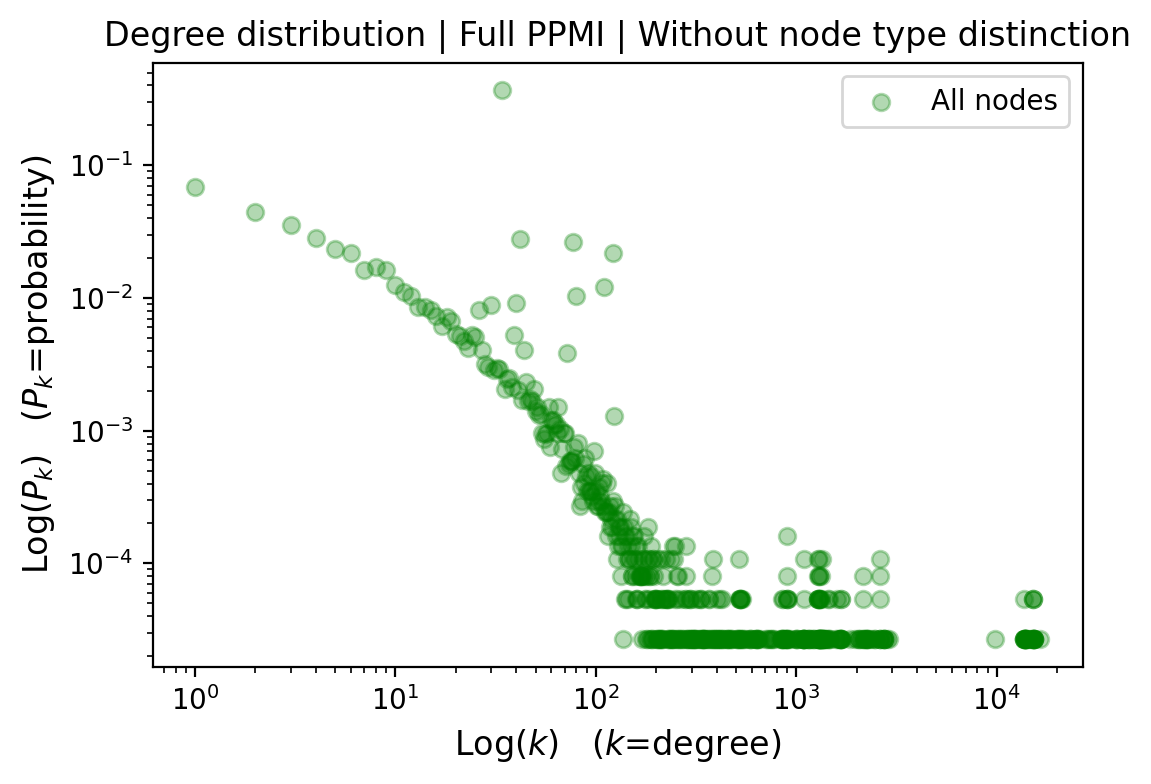

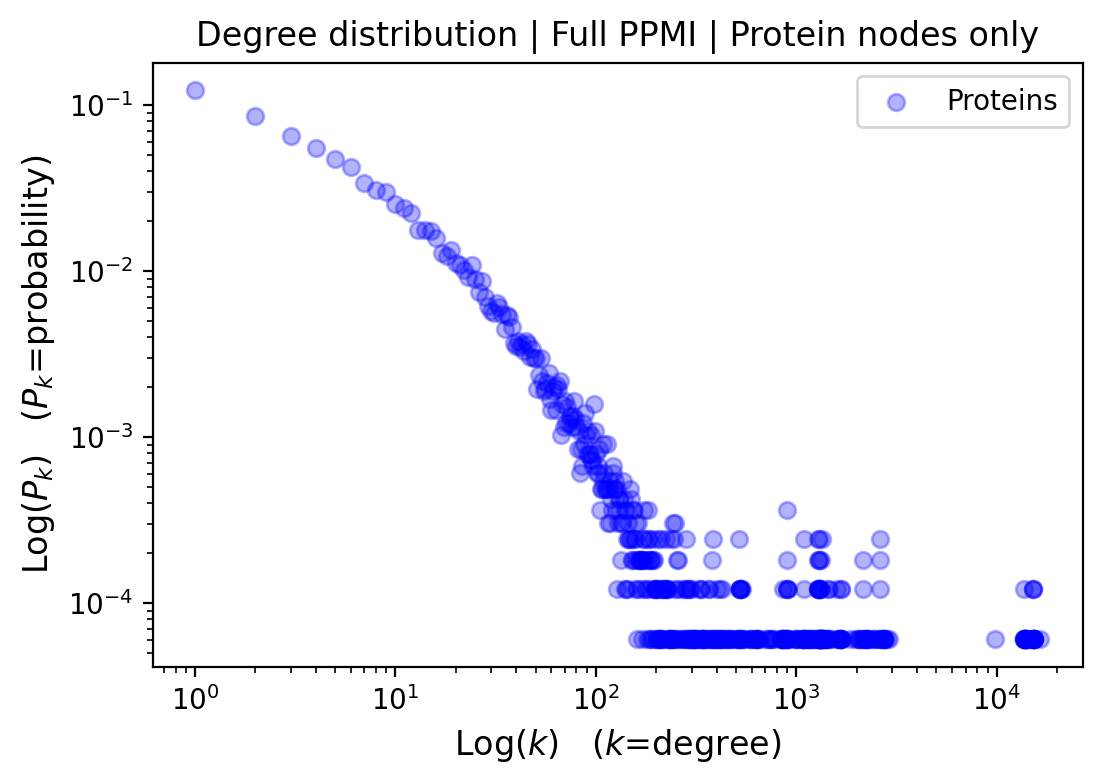

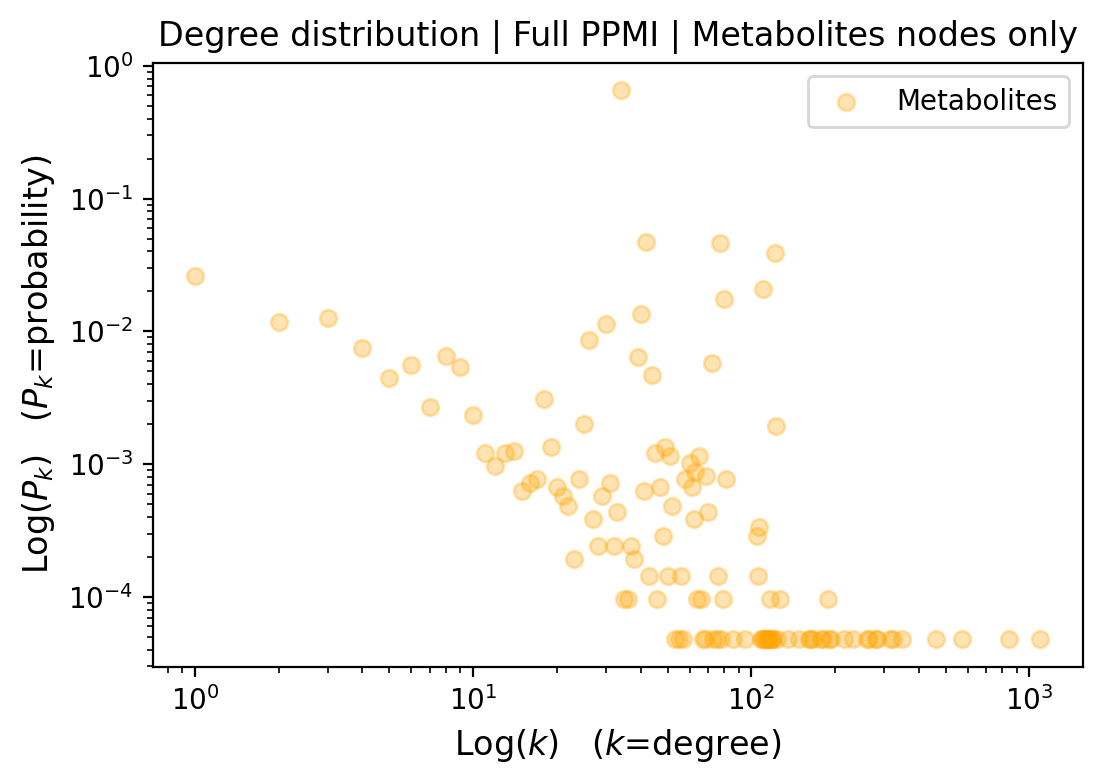

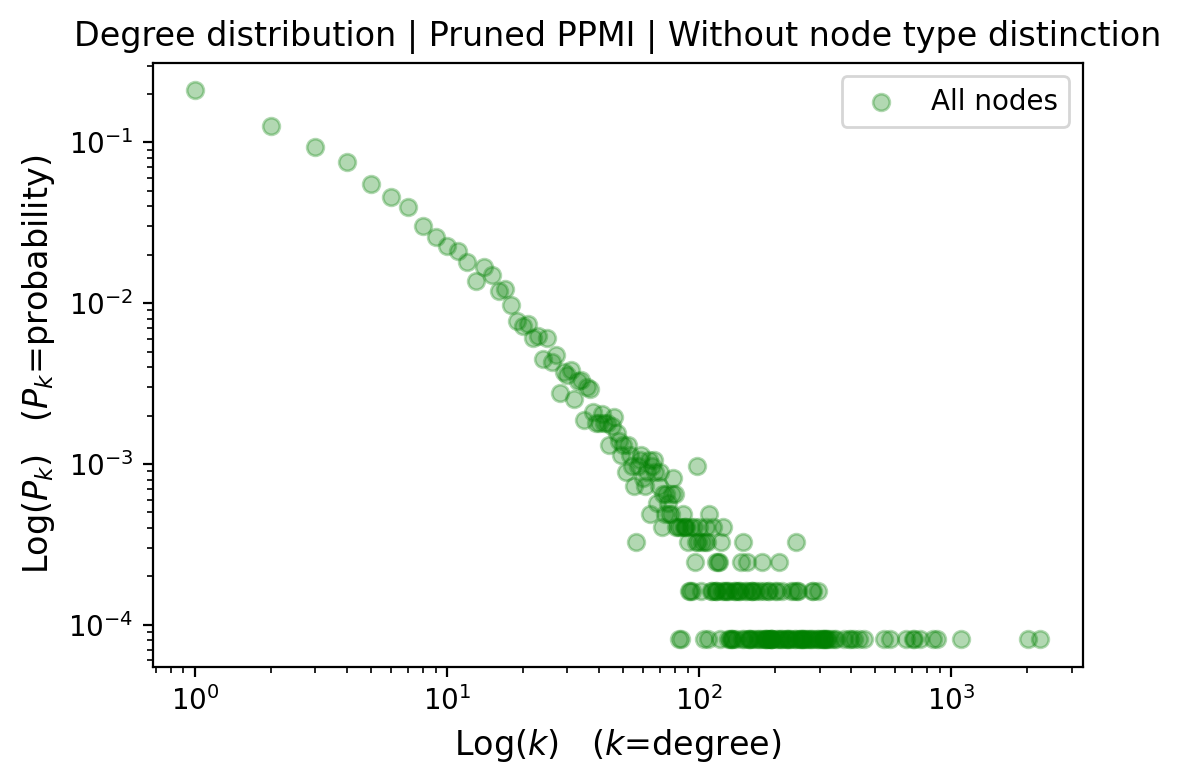

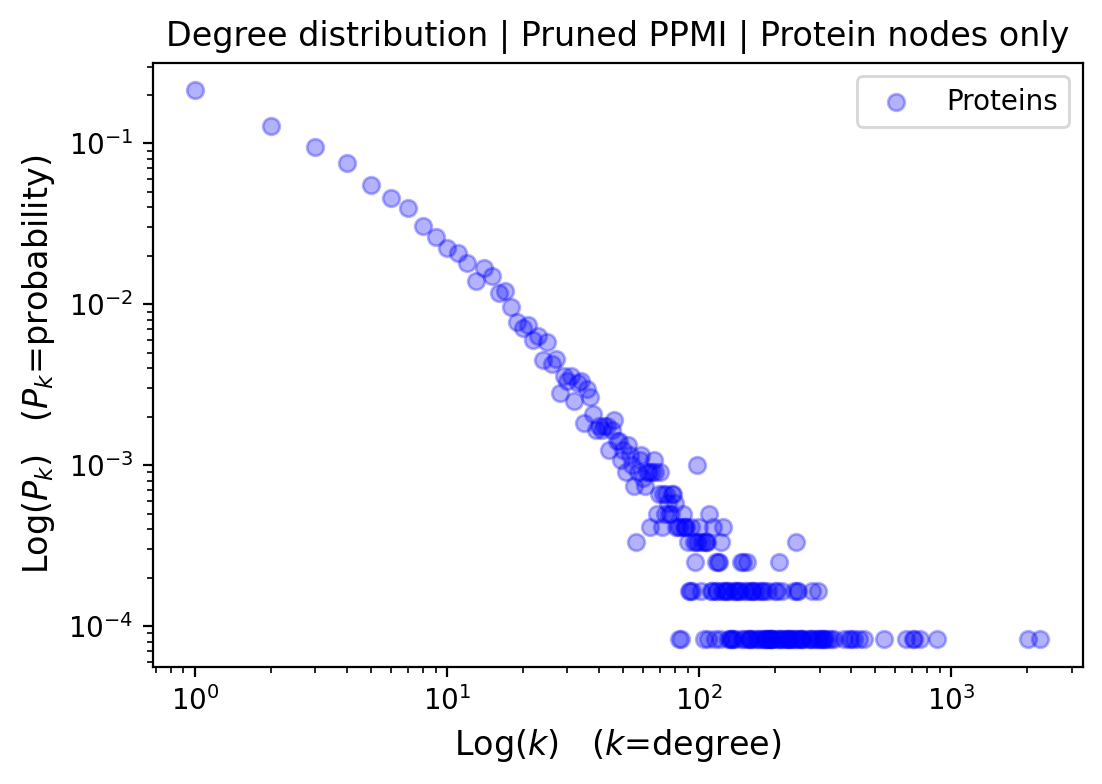

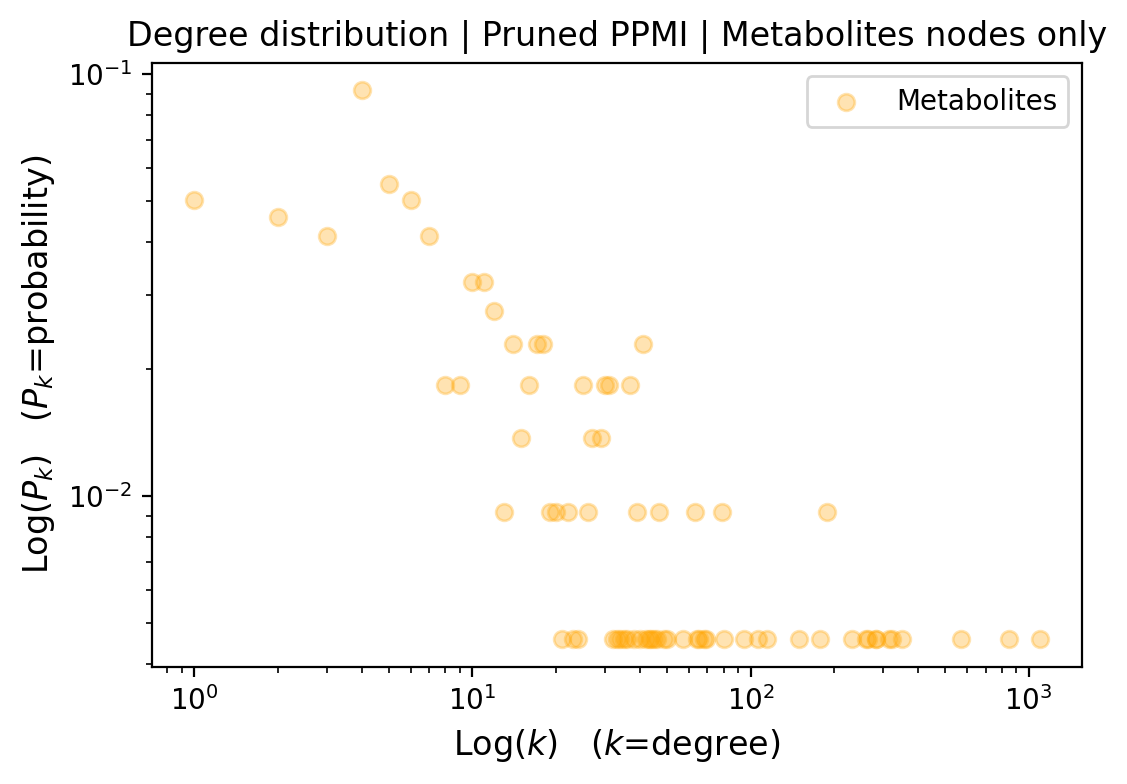

In [132]:
def plot_degree_distribution_per_nodetype(G, plot_metabolites=True, plot_proteins=True, title='', plot_joined=False):
    PPMI_type_mask = np.array([0 if 'HMDB' in node else 1 for node in G.nodes], dtype='int32')
    
    n_nodes = len(G.nodes)
    n_metabolite_nodes = np.where(PPMI_type_mask==0, 1, 0).sum()
    n_protein_nodes = np.where(PPMI_type_mask==1, 1, 0).sum()

    nodes, degree_count = zip(*list(G.degree))
    degree_value_counts = pd.Series(degree_count, index=nodes).value_counts()
    P_k = degree_value_counts/n_nodes
    
    metabolite_nodes, metabolite_degree_count = zip(*list(compress(list(G.degree), list(PPMI_type_mask == [0]*n_nodes))))
    protein_nodes, protein_degree_count = zip(*list(compress(list(G.degree), list(PPMI_type_mask == [1]*n_nodes))))

    metabolite_degree_value_counts = pd.Series(metabolite_degree_count, index=metabolite_nodes).value_counts()
    metabolite_P_k = metabolite_degree_value_counts/n_metabolite_nodes

    protein_degree_value_counts = pd.Series(protein_degree_count, index=protein_nodes).value_counts()
    protein_P_k = protein_degree_value_counts/n_protein_nodes  

    alpha=.3
    fig = plt.figure(figsize=(6,4), dpi=200)
    
    if plot_proteins and plot_metabolites and plot_joined:
        plt.scatter(P_k.index, P_k, color='green', alpha=alpha, label='All nodes')
    else:
        if plot_proteins:
            plt.scatter(protein_P_k.index, protein_P_k, color='blue', alpha=alpha, label='Proteins')
        if plot_metabolites:
            plt.scatter(metabolite_P_k.index, metabolite_P_k, color='orange', alpha=alpha, label='Metabolites')

    plt.yscale('log')
    plt.xscale('log')
    
    fontsize_labels=12
    plt.xlabel('Log($k$)   ($k$=degree)', fontsize=fontsize_labels)
    plt.ylabel('Log($P_k$)   ($P_k$=probability)', fontsize=fontsize_labels)
    plt.legend()
    plt.title(title)
    plt.show()

general_title = 'Degree distribution'    
graph_name = 'Full PPMI'
plot_degree_distribution_per_nodetype(dataloader.PPMI_full, title=f'{general_title} | {graph_name} | Without node type distinction', plot_joined=True)
# plot_degree_distribution_per_nodetype(dataloader.PPMI_full, title=f'{general_title} | {graph_name} | With node type distinction', plot_joined=False)
plot_degree_distribution_per_nodetype(dataloader.PPMI_full, plot_metabolites=False, title=f'{general_title} | {graph_name} | Protein nodes only')
plot_degree_distribution_per_nodetype(dataloader.PPMI_full, plot_proteins=False, title=f'{general_title} | {graph_name} | Metabolites nodes only')

graph_name = 'Pruned PPMI'
plot_degree_distribution_per_nodetype(dataloader.PPMI_pruned, title=f'{general_title} | {graph_name} | Without node type distinction', plot_joined=True)
# plot_degree_distribution_per_nodetype(dataloader.PPMI_pruned, title=f'{general_title} | {graph_name} | With node type distinction', plot_joined=False)
plot_degree_distribution_per_nodetype(dataloader.PPMI_pruned, plot_metabolites=False, title=f'{general_title} | {graph_name} | Protein nodes only')
plot_degree_distribution_per_nodetype(dataloader.PPMI_pruned, plot_proteins=False, title=f'{general_title} | {graph_name} | Metabolites nodes only')